# Discontinuous Galerkin Discretizations (Unit 3.3)
We are solving the scalar linear transport problem

Find $u : [0,T] \rightarrow V_D := \{u \in L^2(\Omega), \ b \cdot \nabla u \in L^2(\Omega), u|_{\Gamma_{in}} = u_D\}$ s.t.
$$\int_\Omega (\partial_t u)v + (b \cdot \nabla u)v = \int_\Omega fv \hspace{3em} \forall v \in V_0  := \{u \in L^2(\Omega), b \cdot \nabla u \in L^2(\Omega), u|_{\Gamma_{in}} = 0\}$$

In [1]:
import netgen.gui
%gui tk
import tkinter
from math import pi
from ngsolve import *
from netgen.geom2d import SplineGeometry


As a first example, we consider the unit square $(0,1)^2$ and the advection velocity $b=(1,2)$. Accordingly the inflow boundary is $\Gamma_{in}=\lbrace x \cdot y=0 \rbrace.$

In [2]:
geo = SplineGeometry()
geo.AddRectangle( (0, 0), (1, 1), 
                 bcs = ("bottom", "right", "top", "left"))
mesh = Mesh( geo.GenerateMesh(maxh=0.2))



We consider an Upwind DG discretization (in space):

Find $u:[0,T]\rightarrow V_h:=\oplus_{T \in \mathcal{T_h}}\mathcal{P}^k(T)$ so that

$$\sum_T \int_T \partial_t uv + b \cdot \nabla uv + \int_{\partial T} b_n(\hat{u} - u)v = \int_\Omega fv, \hspace{2em}\forall v \in V_h.$$

Here $\hat{u}$ is the Upwind flux, i.e. $\hat{u} = u$ on the outflow boundary part $\partial T_{out} = \lbrace x \in \partial T\ |\  b(x) \cdot n_{T}(x) \ge 0 \rbrace$ of $T$ and $\hat{u} = u^{other}$ else, with $u^{other}$ the value from the neighboring element.

There is quite a difference in the computational costs (compared to a standard DG formulation) depending on the question if the solution of linear systems is involved or only operator evaluations (explicit method). We treat both cases separately:

- Solution of the time-dependent problem by explicit time stepping
- Solution of the stationary problem

## Explicit time stepping with a DG formulation

Explicit Euler:
$$\sum_T \int_T u^{n+1}v = \sum_T \int_T u^{n}v - \Delta t \sum_T \int_T \left\lbrace b \cdot \nabla uv + \int_{\partial T} b_n (\hat{u} - u)v - \int_\Omega fv \right\rbrace, \hspace{2em} \forall v \in V_h$$

$$M u^{n+1} = M u^n -\Delta t C u^n + \Delta t f$$

In our first example we set $u_0=f=0$


### Computing convection applications $Cu^n$

We compute $Cu^n$ and define the corresponding bilinear form $C$

. Some remarks on that:

- We can define the bilinear form without setting up a matrix. The operator application is the only thing we want to use from the bilinear form
- A ```BilinearForm``` is allowed to be nonlinear in the 1st argument (for operator applications). We set up a BilinearForm which is technically not bilinear, but only affine linear in the first argument
- For the DG formulation, we require integrals on element boundaries. We use the keyword ```element_boundary``` to obtain quadrature rules for this.
- To distinguish inflow from outflow we take compute $b\cdot n$ Here the normal $n$ is available as a specialcf which has meaningful values on the skeleton, element boundaries or domain boundaries.
- To make cases with `CoefficientFunctions` we use the `IfPos`-`CoefficientFunction`. **`IfPos(a,b,c)`**. `a` decides on the evaluation. If `a` is positive `b` is evaluated, otherwise `c`.

- To access the neighbor variables we can use **u.Other()**

- To incorporate boundary conditions ($\hat{u}$ on inflow boundaries), we can use the argument `bnd` of `.Other(bnd)`.  If there is no neighbor element (boundary!) the `CoefficientFunction` `bnd` is evaluated.

In [3]:
b = CoefficientFunction((1,2))
n = specialcf.normal(mesh.dim)
ubnd = IfPos(x,1,0)

V = L2(mesh,order=2)
u,v = V.TrialFunction(), V.TestFunction()

c = BilinearForm(V)
c += SymbolicBFI( b * grad(u) * v)
c += SymbolicBFI( IfPos( (b*n), 0, (b*n) * (u.Other(ubnd)-u)) * v, element_boundary=True)

gfu_expl = GridFunction(V)
Draw(gfu_expl,mesh,"u_explicit")

res = gfu_expl.vec.CreateVector()
c.Apply(gfu_expl.vec,res)


### Solving mass matrix problems

- To implement the explicit Euler method we now only need to invert the mass matrix. 
- For DG methods the mass matrix is block diagonal, often even diagonal. 
- Instead of setting up a matrix and inverting it, in NGSolve the FESpace provides a routine SolveM which realizes the operation $M^{−1}u$. Note that this function might only be implemented for some spaces (e.g. $L_2$).

In [4]:
t = 0
dt = 0.001
tend = 1

while t < tend-0.5*dt:
    c.Apply(gfu_expl.vec,res)
    V.SolveM(res, CoefficientFunction(1.0))
    gfu_expl.vec.data -= dt * res
    t += dt
    Redraw(blocking=True)


### Notes:
I guess that since our space is already L2, we don't need to specify the distcontinuous flag as we did in Facet Spaces and Hybrid Methods.

I guess we didn't need to specify dgjumps for the space to allocate storage since we didn't assemble the bilinear form.  Hey I was right! read on...

Below we check the sparsity pattern for a **zero** order L2 space.  I think the basis consists of constant values with no overlap.  If you set order 0 for an H1 space (which doesn't really make sense), I think you actually get order 1 (the sparsity patterns are the same)



## Solving linear systems with a DG formulation

(This is partially a repitition of unit-2.8)

When it comes to solving linear systems with a DG formulation we have to change the way the sparsity pattern is typically constructed.
### Sparsity patterns in NGSolve

- The sparsity pattern of a standard FEM matrix and the pattern of a DG matrix is different due to the different couplings. 
- In NGSolve the sparsity pattern is set up whenever a bilinear form is assembled
- the sparsity pattern is generated based on the finite element space only (and not the integrators!).

There are two cases:
#### 1. Standard formulation

- In a standard formulation dofs (degrees of freedom) only couple (have a nonzero entry) if the support of the corresponding basis functions overlap. 
- In NGSolve this sparsity pattern is obtained by allocating nonzero entries whenever two unknowns have an association with the same element.
- (previous explanation: sparsity pattern is achieved by associating all elements to a dof where the basis function is supported. Finally, for all dofs that are on elements associated with a dof a nonzero entry is reserved in the matrix. This work fine for all types of finite element spaces (H1, L2, Hdiv, Hcurl, etc..) and only depends on the 'GetDofNrs' function of a finite element space.

The idea is sketched here for one dof:

dof $\rightarrow$ elements of dof = $[\text{el}_1,\dots,\text{el}_n] \rightarrow$ dofs of $(\text{el}_1)$ $\cup\dots\cup$ dofs of $(\text{el}_n)$.
#### 2. DG formulation ('dgjumps')

In a DG formulation couplings (nonzero entries) are introduced also for basis functions which do not have overlapping support. Therefore a different mechanism (keyword: 'dgjumps') has been introduced to determine the sparsity pattern. This can be activated by adding the 'dgjumps' flags to the FESpace. Note that we do not need the flag if we do not set up matrices (explicit time stepping).

In a dgjumps-formulation additional couplings are introduced through facets. i.e. for all dofs that associate to the same facet, a nonzero entery is reserved. 

(previous explanation) All dofs of the neighboring elements of a facet are associated with a facet and then for all dofs that are associated to facets associated with a dof a nonzero entry is reserved in a matrix.

The idea is sketched here for one dof:

dof $\rightarrow$ facets of dof = $[\text{fac}_1,\dots,\text{fac}_n] \rightarrow$  dofs of $(\text{fac}_1) \cup\dots\cup$ dofs of $(\text{fac}_n)$.

Note that 'dofs of facet $F$' is always larger than 'dofs of element $T$' if $F\subset\partial T$.

We want to demonstrate the difference in the sparsity pattern with a simple comparison in the next block


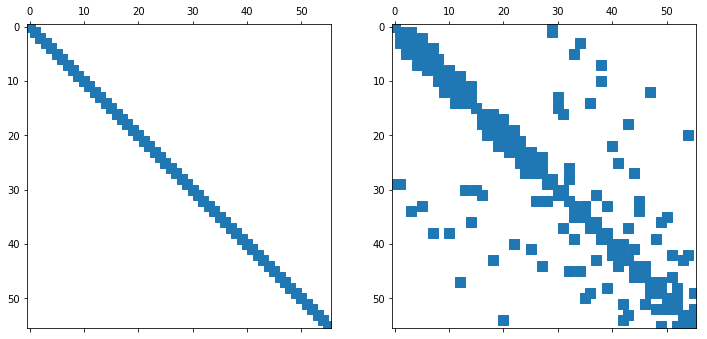

In [5]:
%matplotlib inline
V1 = L2(mesh,order=0)
a1 = BilinearForm(V1)
a1.Assemble()

V2 = L2(mesh,order=0, dgjumps=True)
a2 = BilinearForm(V2)
a2.Assemble()

import scipy.sparse as sp
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = (12, 12)

a1.mat.AsVector()[:] = 1 # set every entry to 1
rows,cols,vals = a1.mat.COO()
A1 = sp.csr_matrix((vals,(rows,cols)))
a2.mat.AsVector()[:] = 1 # set every entry to 1
rows,cols,vals = a2.mat.COO()
A2 = sp.csr_matrix((vals,(rows,cols)))
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.spy(A1) # sparsity pattern of a sparse array - can be called direclty from pyplot
ax2.spy(A2)
plt.show()

* when assembling a `BilinearForm` the bilinear form has to be **linear** in both arguments again (Linearizations will be addressed later)
* `...Other(bnd=..)` does not make sense any more
* when setting up the system we require `LinearForm` and `BilinearForm`s separately to implement boundary conditions.

In [6]:
b = CoefficientFunction((1,2))
n = specialcf.normal(mesh.dim)
ubnd = IfPos(x,1,0)

V = L2(mesh,order=2, dgjumps=True)
a = BilinearForm(V)
u,v = V.TrialFunction(), V.TestFunction()
a += SymbolicBFI( b * grad(u) * v)
a += SymbolicBFI( IfPos( (b*n), 0, (b*n) * (u.Other()-u)) * v, element_boundary=True)
a.Assemble()

f = LinearForm(V)
f += SymbolicLFI( (b*n) * IfPos( (b*n), 0, -ubnd) * v, BND, skeleton=True)
f.Assemble()

In [7]:
gfu_impl = GridFunction(V)
gfu_impl.vec.data = a.mat.Inverse() * f.vec
Draw(gfu_impl,mesh,"u_implicit")


**Note (DD):**  This is working correctly now, I think.  Previously the solution $u_{implicit}$ is mostly infs and nans.  I don't think the tutorial code changed so probably something in the back end.


### Remarks on sparsity pattern in NGSolve
#### Remark 1: The sparsity pattern is set up a-priorily

The sparsity pattern of a sparse matrix in NGSolve is independent of its entries (it's set up before matrix assembly). It can happen that some of the entries remain zero after assembly. Below we show the reserved memory for the sparse matrix and the (numerically) non-zero entries in this sparse matrix.

(you need matplotlib/scipy for this block - but can ignore it otherwise)


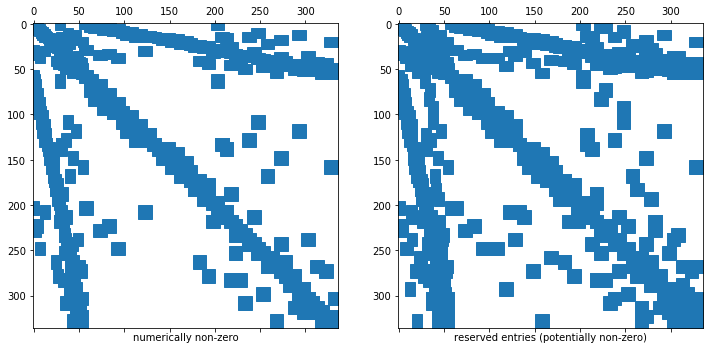

In [8]:
import scipy.sparse as sp
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = (12, 12)
rows,cols,vals = a.mat.COO()
A1 = sp.csr_matrix((vals,(rows,cols)))
A2 = A1.copy()
A2.data[:] = 1
fig = plt.figure()
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)
ax1.set_xlabel("numerically non-zero")
ax1.spy(A1)
ax2.set_xlabel("reserved entries (potentially non-zero)")
ax2.spy(A2)
plt.show()



#### Remark 2: Dof numbering of higher order FESpaces

In NGSolve FESpaces typically have a numbering where the first block of dofs corresponds to a low order subspace (which is convenient for iterative solvers). For L2 this means that the first dofs correspond to the constants on elements.

You can turn this behavior of for some spaces, e.g. for L2 by adding the flag "all_dofs_together".

We demonstrate this in the next comparison:

(you need matplotlib/scipy for this block - but can ignore it otherwise)


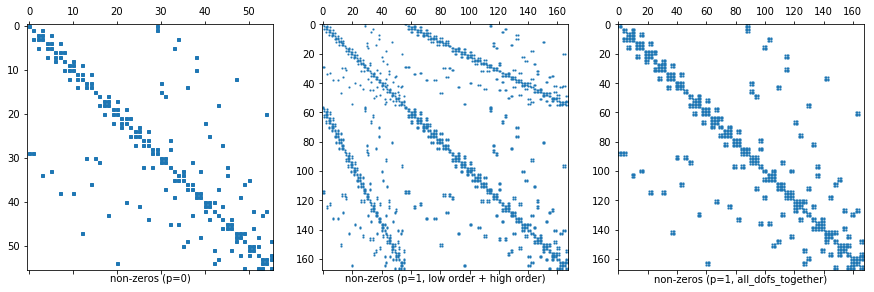

In [9]:
V0 = L2(mesh,order=0, dgjumps=True)
a0 = BilinearForm(V0)
a0.Assemble()

V1 = L2(mesh,order=1, dgjumps=True)
a1 = BilinearForm(V1)
a1.Assemble()

V2 = L2(mesh,order=1, dgjumps=True, all_dofs_together=True)
a2 = BilinearForm(V2)
a2.Assemble()

import scipy.sparse as sp
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = (15, 15)

a0.mat.AsVector()[:] = 1 # set every entry to 1
rows,cols,vals = a0.mat.COO()
A0 = sp.csr_matrix((vals,(rows,cols)))
a1.mat.AsVector()[:] = 1 # set every entry to 1
rows,cols,vals = a1.mat.COO()
A1 = sp.csr_matrix((vals,(rows,cols)))
a2.mat.AsVector()[:] = 1 # set every entry to 1
rows,cols,vals = a2.mat.COO()
A2 = sp.csr_matrix((vals,(rows,cols)))
fig = plt.figure()
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.set_xlabel("non-zeros (p=0)")
ax1.spy(A0,markersize=3)
ax2.set_xlabel("non-zeros (p=1, low order + high order)")
ax2.spy(A1,markersize=1)
ax3.set_xlabel("non-zeros (p=1, all_dofs_together)")
ax3.spy(A2,markersize=1)
plt.show()

# Supplementary 1: Skeleton formulation

So far we considered the DG formulation with integrals on the boundary of each element. Instead one could formulate the problem in terms of facet integrals where every facet appears only once. 

Then, the corresponding formulation is:

Find $u: [0,T] \to V_h := \bigoplus_{T\in\mathcal{T}_h} \mathcal{P}^k(T)$ so that
$$
  \sum_{T} \int_T \partial_t u v + b \cdot \nabla u v + \sum_{F\in\mathcal{F}^{int}} \int_{F} b_n (u^{neighbor} - u) v^{downwind} + \sum_{F\in\mathcal{F}^{inflow}} \int_{F} b_n (u^{inflow}-u) v = \int_{\Omega} f v , \quad \forall v \in V_h.
$$
Here $\mathcal{F}^{int}$ is the set of interior facets and $\mathcal{F}^{inflow}$ is the set of boundary facets where $b \cdot \mathbf{n} < 0$. $v^{downwind}$ is the function on the downwind side of the facet and $u^{inflow}$ is the inflow boundary condition. 

In NGSolve these integrals can be assembled with `skeleton=True`. The facet integrals are divided into interior facets and exterior (boundary) facet. Hence, we add `BND`/`VOL`:

In [10]:
b = CoefficientFunction((1,2))
n = specialcf.normal(mesh.dim)
ubnd = IfPos(x,1,0)

V = L2(mesh,order=2)
u,v = V.TrialFunction(), V.TestFunction()

c = BilinearForm(V)
c += SymbolicBFI( b * grad(u) * v)

bn = b*n
vin = IfPos(bn,v.Other(),v)
c += SymbolicBFI( bn*(u.Other() - u) * vin, VOL, skeleton=True)
c += SymbolicBFI( IfPos(bn, 0, bn) * (u.Other(ubnd) - u) * v, BND, skeleton=True)

gfu_expl = GridFunction(V)
Draw(gfu_expl,mesh,"u_explicit")

res = gfu_expl.vec.CreateVector()
c.Apply(gfu_expl.vec,res)

In [11]:
t = 0
dt = 0.001
tend = 1

while t < tend-0.5*dt:
    c.Apply(gfu_expl.vec,res)
    V.SolveM(res,rho=CoefficientFunction(1.0))
    gfu_expl.vec.data -= dt * res
    t += dt
    Redraw(blocking=True)

# Supplementary 2: DG for Diffusion  

DG formulation for the Poisson problem
$$\text{find: } u \in H_{0,D}^1 \quad \int_\Omega \nabla u \nabla v = \int_\Omega f v \quad \forall v \in H_{0,D}^1$$

For the non-conforming discretization we use the $L^2$ space and the (symmetric) interior penalty method:
Find $u \in V_h := \bigoplus_{T\in\mathcal{T}_h} \mathcal{P}^k(T)$ so that
\begin{align}
  & \sum_{T} \int_T \nabla u \nabla v + \sum_{F\in\mathcal{F}^{int}} \int_{F} \{\!\!\{ - \nabla u \cdot n \}\!\!\} [\![v]\!] +  \{\!\!\{ - \nabla v \cdot n \}\!\!\} [\![u]\!] +  \frac{\alpha}{h} [\![u]\!][\![v]\!] \\
  & + \sum_{F\in\mathcal{F}^{ext}} \int_{F} - \nabla u \cdot n v - \nabla v \cdot n u + \frac{\alpha}{h}~ u v = \sum_{F\in\mathcal{F}^{ext}} \int_{F} - \nabla v \cdot n u_{D} + \frac{\alpha}{h} u_{D} v  + \int_{\Omega} f v , \quad \forall v \in V_h.
\end{align}
where $\{\!\!\{\cdot\}\!\!\}$ and $[\![ \cdot ]\!]$ are the usual average and jump operators across facets.

In [12]:
n = specialcf.normal(mesh.dim)
h = specialcf.mesh_size
IfPos(x-y,0,1)
source = IfPos(x-y,5,-5)

order=2
V = L2(mesh,order=order,dgjumps=True)
a = BilinearForm(V)
u,v = V.TrialFunction(), V.TestFunction()
a += SymbolicBFI( grad(u) * grad(v))
def avg_flux(u):
    return 0.5*(-grad(u)*n-grad(u.Other())*n)
def jump(u):
    return u-u.Other()
alpha = 5 * order * (order+1)
a += SymbolicBFI( avg_flux(u) * jump(v) + avg_flux(v) * jump(u) + alpha/h * jump(u) * jump(v), VOL, skeleton=True)
a += SymbolicBFI( - grad(u)*n*v - grad(v)*n*u + alpha/h * u * v, BND, skeleton=True)
a.Assemble()

f = LinearForm(V)
f += SymbolicLFI( (- grad(v)*n + alpha/h * v) * ubnd, BND, skeleton=True)
f += SymbolicLFI( source * v)
f.Assemble()

gfu_impl = GridFunction(V)
gfu_impl.vec.data = a.mat.Inverse() * f.vec
Draw(gfu_impl,mesh,"u_implicit")